In [1]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm
%matplotlib inline 


In [2]:
file_path_list = []
for dirname, _, filenames in os.walk('../data/fhir'):
    for filename in filenames:
        file_path_list.append((dirname, filename))

In [3]:
metadata_df = pd.DataFrame(file_path_list, columns=["folder", "file"])
print(f"Files: {metadata_df.shape[0]}")

Files: 129218


In [4]:
metadata_df.head()

,folder,file
0,../data/fhir/61/610,6103fd70-e4ea-41ed-95d6-6217315a1736.json
1,../data/fhir/61/610,610aaba7-011f-4021-b2ef-419cd0f932d7.json
2,../data/fhir/61/610,610f16f7-dcd3-43c7-ba8b-f5265999550b.json
3,../data/fhir/61/610,61011ab5-88e1-4c2f-b1dd-b01d73011121.json
4,../data/fhir/61/610,61088539-efe1-41f6-a6e8-59083da17cac.json


In [5]:
def extract_subgroup(path):
    return path.split("/")[-1]

def extract_group(path):
    return path.split("/")[-2]

In [6]:
metadata_df["group"] = metadata_df["folder"].apply(lambda x: extract_group(x))
metadata_df["subgroup"] = metadata_df["folder"].apply(lambda x: extract_subgroup(x))
metadata_df = metadata_df[["folder", "group", "subgroup", "file"]]
metadata_df.head()

,folder,group,subgroup,file
0,../data/fhir/61/610,61,610,6103fd70-e4ea-41ed-95d6-6217315a1736.json
1,../data/fhir/61/610,61,610,610aaba7-011f-4021-b2ef-419cd0f932d7.json
2,../data/fhir/61/610,61,610,610f16f7-dcd3-43c7-ba8b-f5265999550b.json
3,../data/fhir/61/610,61,610,61011ab5-88e1-4c2f-b1dd-b01d73011121.json
4,../data/fhir/61/610,61,610,61088539-efe1-41f6-a6e8-59083da17cac.json


In [7]:
print(f"Folders: {metadata_df.folder.nunique()}")
print(f"Groups: {metadata_df.group.nunique()}")
print(f"Subgroups: {metadata_df.subgroup.nunique()}")
print(f"Files: {metadata_df.file.nunique()}")

Folders: 4080
Groups: 255
Subgroups: 4080
Files: 129218


In [8]:
sample_df= pd.read_json('../data/fhir/d8/d8c/d8cddeba-4cf8-412a-86de-b9af0a6a185b.json')
sample_df.head()

,type,entry,resourceType
0,collection,{'fullUrl': 'urn:uuid:f7b73132-64f0-462b-8ca5-...,Bundle
1,collection,{'fullUrl': 'urn:uuid:ab801624-bfef-410f-8e75-...,Bundle
2,collection,{'fullUrl': 'urn:uuid:224407fa-cf73-41d2-aee3-...,Bundle
3,collection,{'fullUrl': 'urn:uuid:d66f0cc2-20f0-49b0-9883-...,Bundle
4,collection,{'fullUrl': 'urn:uuid:63f1c8f9-279c-4fae-8aef-...,Bundle


In [9]:
patient_df = pd.DataFrame() 
careplan_df = pd.DataFrame() 
condition_df = pd.DataFrame() 
diagnostic_report_df = pd.DataFrame() 
encounter_df = pd.DataFrame() 
immunization_df = pd.DataFrame() 
observation_df = pd.DataFrame() 
procedure_df = pd.DataFrame() 

In [10]:
def process_one_file(sample_df,
                    patient_df,
                    careplan_df,
                    condition_df,
                    diagnostic_report_df,
                    encounter_df,
                    immunization_df,
                    observation_df,
                    procedure_df):
    
    dataframe_list = [patient_df, careplan_df, condition_df, diagnostic_report_df,
                 encounter_df, immunization_df, observation_df, procedure_df]
    
    for index, row in sample_df.iterrows():
        resourcetype=set()
        tempdf=pd.json_normalize(row.entry)
        resourcetype.add([str(x) for x in tempdf['resource.resourceType']][0])

        if str(tempdf['resource.resourceType'][0])=="Patient":
            frames = [patient_df, tempdf]
            patient_df = pd.concat(frames)

        elif str(tempdf['resource.resourceType'][0])=="CarePlan":
            frames = [careplan_df, tempdf]
            careplan_df = pd.concat(frames)

        elif str(tempdf['resource.resourceType'][0])=="Condition":
            frames = [condition_df, tempdf]
            condition_df = pd.concat(frames)

        elif str(tempdf['resource.resourceType'][0])=="DiagnosticReport":
            frames = [diagnostic_report_df, tempdf]
            diagnostic_report_df = pd.concat(frames)

        elif str(tempdf['resource.resourceType'][0])=="Encounter":
            frames = [encounter_df, tempdf]
            encounter_df = pd.concat(frames)

        elif str(tempdf['resource.resourceType'][0])=="Immunization":
            frames = [immunization_df, tempdf]
            immunization_df = pd.concat(frames)

        elif str(tempdf['resource.resourceType'][0])=="Observation":
            frames = [observation_df, tempdf]
            observation_df = pd.concat(frames)

        elif str(tempdf['resource.resourceType'][0])=="Procedure":
            frames = [procedure_df, tempdf]
            procedure_df = pd.concat(frames)   

    return patient_df,\
                    careplan_df,\
                    condition_df,\
                    diagnostic_report_df,\
                    encounter_df,\
                    immunization_df,\
                    observation_df,\
                    procedure_df

In [11]:
def clean_and_rename(patient_df,
                    careplan_df,
                    condition_df,
                    diagnostic_report_df,
                    encounter_df,
                    immunization_df,
                    observation_df,
                    procedure_df):
    for df in [patient_df, careplan_df, condition_df, diagnostic_report_df,
                 encounter_df, immunization_df, observation_df, procedure_df]:
        df.columns = df.columns.str.replace(".", "_")
        df.columns = df.columns.str.replace("resource_", "")
    
    for df in [patient_df, observation_df, encounter_df]:
        df['fullUrl']= df['fullUrl'].str.replace('urn:uuid:', '')
        
    for df in [careplan_df, condition_df, diagnostic_report_df]:
        df['subject_reference']=df['subject_reference'].str.replace('urn:uuid:', '')
        df['context_reference']=df['context_reference'].str.replace('urn:uuid:', '')
    
    for df in [encounter_df, immunization_df]:
        df['patient_reference'] = df['patient_reference'].str.replace('urn:uuid:', '')
        
    for df in [immunization_df]:
        df['encounter_reference'] = df['encounter_reference'].str.replace('urn:uuid:', '')
        
    for df in [observation_df, procedure_df]:
        df['subject_reference'] = df['subject_reference'].str.replace('urn:uuid:', '')
        df['encounter_reference'] = df['encounter_reference'].str.replace('urn:uuid:', '')
        
    return patient_df,\
                    careplan_df,\
                    condition_df,\
                    diagnostic_report_df,\
                    encounter_df,\
                    immunization_df,\
                    observation_df,\
                    procedure_df


In [12]:
patient_df,\
careplan_df,\
condition_df,\
diagnostic_report_df,\
encounter_df,\
immunization_df,\
observation_df,\
procedure_df = \
process_one_file(sample_df,patient_df,
careplan_df,
condition_df,
diagnostic_report_df,
encounter_df,
immunization_df,
observation_df,
procedure_df)

In [13]:
patient_df.head()

,fullUrl,resource.id,resource.text.status,resource.text.div,resource.extension,resource.identifier,resource.name,resource.telecom,resource.gender,resource.birthDate,resource.address,resource.maritalStatus.coding,resource.multipleBirthBoolean,resource.photo,resource.resourceType
0,urn:uuid:f7b73132-64f0-462b-8ca5-94dc5205b297,f7b73132-64f0-462b-8ca5-94dc5205b297,generated,"<div>Generated by <a href=""https://github.com/...",[{'url': 'http://hl7.org/fhir/StructureDefinit...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Botsford730', ...",[{'extension': [{'url': 'http://standardhealth...,male,1987-10-12,[{'extension': [{'extension': [{'url': 'latitu...,[{'system': 'http://hl7.org/fhir/v3/MaritalSta...,False,"[{'contentType': 'image/png', 'data': 'iVBORw0...",Patient


In [14]:
sel_index = list(metadata_df.group.value_counts()[0:2].index)
sel_index

['d6', 'e1']

In [15]:
group_df = metadata_df.loc[metadata_df.group.isin(sel_index)]

In [16]:
group_df.shape[0], group_df.shape[0] / metadata_df.shape[0]

(1119, 0.008659784240585677)

## Select 1.1k entries, or less than 1% of data

In [17]:
patient_df = pd.DataFrame() 
careplan_df = pd.DataFrame() 
condition_df = pd.DataFrame() 
diagnostic_report_df = pd.DataFrame() 
encounter_df = pd.DataFrame() 
immunization_df = pd.DataFrame() 
observation_df = pd.DataFrame() 
procedure_df = pd.DataFrame() 

In [18]:
for index, row in tqdm(group_df.iterrows()):
    folder = row["folder"]
    file = row["file"]
    sample_df = pd.read_json(os.path.join(folder, file))
    patient_df,\
    careplan_df,\
    condition_df,\
    diagnostic_report_df,\
    encounter_df,\
    immunization_df,\
    observation_df,\
    procedure_df = \
    process_one_file(sample_df,patient_df,
    careplan_df,
    condition_df,
    diagnostic_report_df,
    encounter_df,
    immunization_df,
    observation_df,
    procedure_df)

1119it [02:28,  7.55it/s]


## WOW... that's hot...

### Let's check the size for each

In [19]:
patient_df.shape[0], careplan_df.shape[0], condition_df.shape[0], diagnostic_report_df.shape[0], encounter_df.shape[0], immunization_df.shape[0],\
observation_df.shape[0], procedure_df.shape[0]

(1119, 2115, 4125, 2681, 10298, 7421, 41520, 4757)

In [20]:
for df in [patient_df, careplan_df, condition_df, diagnostic_report_df, encounter_df, immunization_df, observation_df,procedure_df]:
    print(df.columns)

Index(['fullUrl', 'resource.id', 'resource.text.status', 'resource.text.div',
       'resource.extension', 'resource.identifier', 'resource.name',
       'resource.telecom', 'resource.gender', 'resource.birthDate',
       'resource.deceasedDateTime', 'resource.address',
       'resource.maritalStatus.coding', 'resource.multipleBirthBoolean',
       'resource.photo', 'resource.resourceType',
       'resource.multipleBirthInteger'],
      dtype='object')
Index(['resource.status', 'resource.category', 'resource.subject.reference',
       'resource.context.reference', 'resource.period.start',
       'resource.addresses', 'resource.activity', 'resource.resourceType',
       'resource.period.end'],
      dtype='object')
Index(['fullUrl', 'resource.id', 'resource.clinicalStatus',
       'resource.verificationStatus', 'resource.code.coding',
       'resource.subject.reference', 'resource.context.reference',
       'resource.onsetDateTime', 'resource.resourceType',
       'resource.abatementDat

In [21]:
patient_df.head()

,fullUrl,resource.id,resource.text.status,resource.text.div,resource.extension,resource.identifier,resource.name,resource.telecom,resource.gender,resource.birthDate,resource.deceasedDateTime,resource.address,resource.maritalStatus.coding,resource.multipleBirthBoolean,resource.photo,resource.resourceType,resource.multipleBirthInteger
0,urn:uuid:79768ddb-fa8a-4ce8-b9dd-139d10a3b9a1,79768ddb-fa8a-4ce8-b9dd-139d10a3b9a1,generated,"<div>Generated by <a href=""https://github.com/...",[{'url': 'http://hl7.org/fhir/StructureDefinit...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Moen903', 'giv...",[{'extension': [{'url': 'http://standardhealth...,male,1948-09-12,1989-04-02T17:36:25-04:00,[{'extension': [{'extension': [{'url': 'latitu...,[{'system': 'http://hl7.org/fhir/v3/MaritalSta...,False,"[{'contentType': 'image/png', 'data': 'iVBORw0...",Patient,NaN
0,urn:uuid:1117ae06-e920-4768-a351-f0db77a1edaa,1117ae06-e920-4768-a351-f0db77a1edaa,generated,"<div>Generated by <a href=""https://github.com/...",[{'url': 'http://hl7.org/fhir/StructureDefinit...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Will292', 'giv...",[{'extension': [{'url': 'http://standardhealth...,female,1936-04-27,NaN,[{'extension': [{'extension': [{'url': 'latitu...,[{'system': 'http://hl7.org/fhir/v3/MaritalSta...,False,"[{'contentType': 'image/png', 'data': 'iVBORw0...",Patient,NaN
0,urn:uuid:88c50d56-619e-42b5-a7ba-4c864c2f4f5f,88c50d56-619e-42b5-a7ba-4c864c2f4f5f,generated,"<div>Generated by <a href=""https://github.com/...",[{'url': 'http://hl7.org/fhir/StructureDefinit...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Lemke253', 'gi...",[{'extension': [{'url': 'http://standardhealth...,male,1959-10-29,2015-01-28T22:19:03-05:00,[{'extension': [{'extension': [{'url': 'latitu...,[{'system': 'http://hl7.org/fhir/v3/MaritalSta...,False,"[{'contentType': 'image/png', 'data': 'iVBORw0...",Patient,NaN
0,urn:uuid:a3f267fd-dd43-42da-877a-9d04d6a9bb79,a3f267fd-dd43-42da-877a-9d04d6a9bb79,generated,"<div>Generated by <a href=""https://github.com/...",[{'url': 'http://hl7.org/fhir/StructureDefinit...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Hamill421', 'g...",[{'extension': [{'url': 'http://standardhealth...,male,2015-06-12,NaN,[{'extension': [{'extension': [{'url': 'latitu...,NaN,False,"[{'contentType': 'image/png', 'data': 'iVBORw0...",Patient,NaN
0,urn:uuid:aeb820cc-8a4d-4e4c-89b2-bdd1d7a40e98,aeb820cc-8a4d-4e4c-89b2-bdd1d7a40e98,generated,"<div>Generated by <a href=""https://github.com/...",[{'url': 'http://hl7.org/fhir/StructureDefinit...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Frami969', 'gi...",[{'extension': [{'url': 'http://standardhealth...,male,1985-11-26,NaN,[{'extension': [{'extension': [{'url': 'latitu...,[{'system': 'http://hl7.org/fhir/v3/MaritalSta...,False,"[{'contentType': 'image/png', 'data': 'iVBORw0...",Patient,NaN


In [22]:
def plot_count(feature, title, df, size=1, ordered=True):
    sb.set_theme(style="whitegrid")
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    if ordered:
        g = sb.countplot(x=feature, data=df, order = df[feature].value_counts().index[:20], palette="Set3")
    else:
        g = sb.countplot(x=feature, data = df, palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()    

/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_81878/3288257235.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sb.countplot(x=feature, data=df, order = df[feature].value_counts().index[:20], palette="Set3")


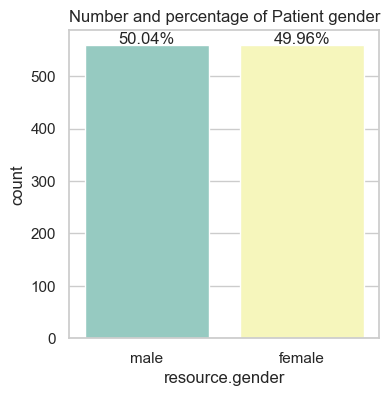

In [23]:
#plot gender count 
plot_count("resource.gender", "Patient gender", df=patient_df, size=1)


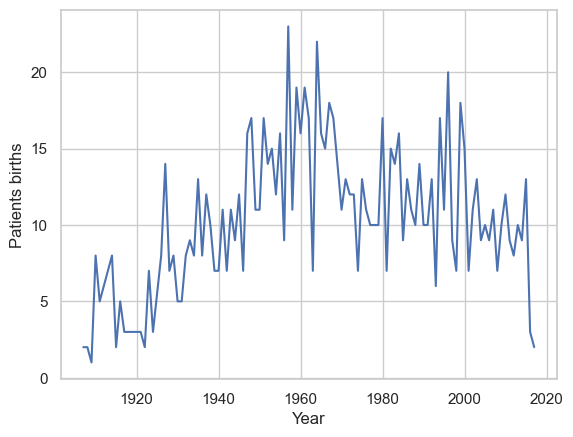

In [24]:
from datetime import datetime as dt
patient_df["birth_date"] = patient_df["resource.birthDate"].apply(lambda x: dt.strptime(x, '%Y-%m-%d'))
patient_df["birth_year"] = patient_df["birth_date"].apply(lambda x: x.year)
agg_year = patient_df.groupby(["birth_year"])["resource.gender"].count().reset_index()
agg_year.columns = ["birth_year", "count"]
plt.plot(agg_year["birth_year"], agg_year["count"])
plt.title = "Patients births / year"
plt.xlabel("Year")
plt.ylabel("Patients births")
plt.show()

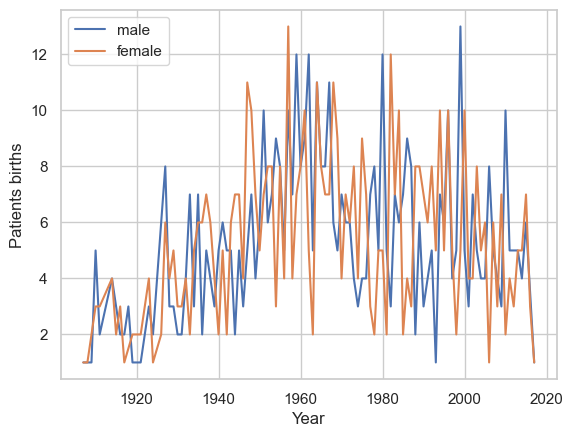

In [25]:
agg_year = patient_df.groupby(["birth_year", "resource.gender"])["resource.telecom"].count().reset_index()
agg_year.columns = ["birth_year", "gender", "count"]
plt.plot(agg_year.loc[agg_year.gender=="male", "birth_year"], agg_year.loc[agg_year.gender=="male", "count"], label="male")
plt.plot(agg_year.loc[agg_year.gender=="female", "birth_year"], agg_year.loc[agg_year.gender=="female", "count"], label="female")
plt.title = "Patients births / year"
plt.xlabel("Year")
plt.ylabel("Patients births")
plt.legend()
plt.show()

In [26]:
def extract_subitems_by_name(item_list, name):
    for item in item_list:
        if item[name]:
            return item[name]
            
def extract_one_subitem_by_name(item_list, name):
    return item_list[0][name]

observation_df["date"] = observation_df["resource.effectiveDateTime"].apply(lambda x: dt.strptime(x[0:10], '%Y-%m-%d'))
observation_df["resource.code.code"] = observation_df["resource.code.coding"].apply(lambda x: extract_one_subitem_by_name(x, 'code'))
observation_df["resource.code.display"] = observation_df["resource.code.coding"].apply(lambda x: extract_one_subitem_by_name(x, 'display'))

/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_81878/46950103.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sb.distplot(sel_df["resource.valueQuantity.value"], color=colors[i%4])
/Users/zakg04/Documents/ZakSchool-Cloud/school-25-S1/HIN-Proj/.conda/lib/python3.11/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_81878/46950103.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level functio

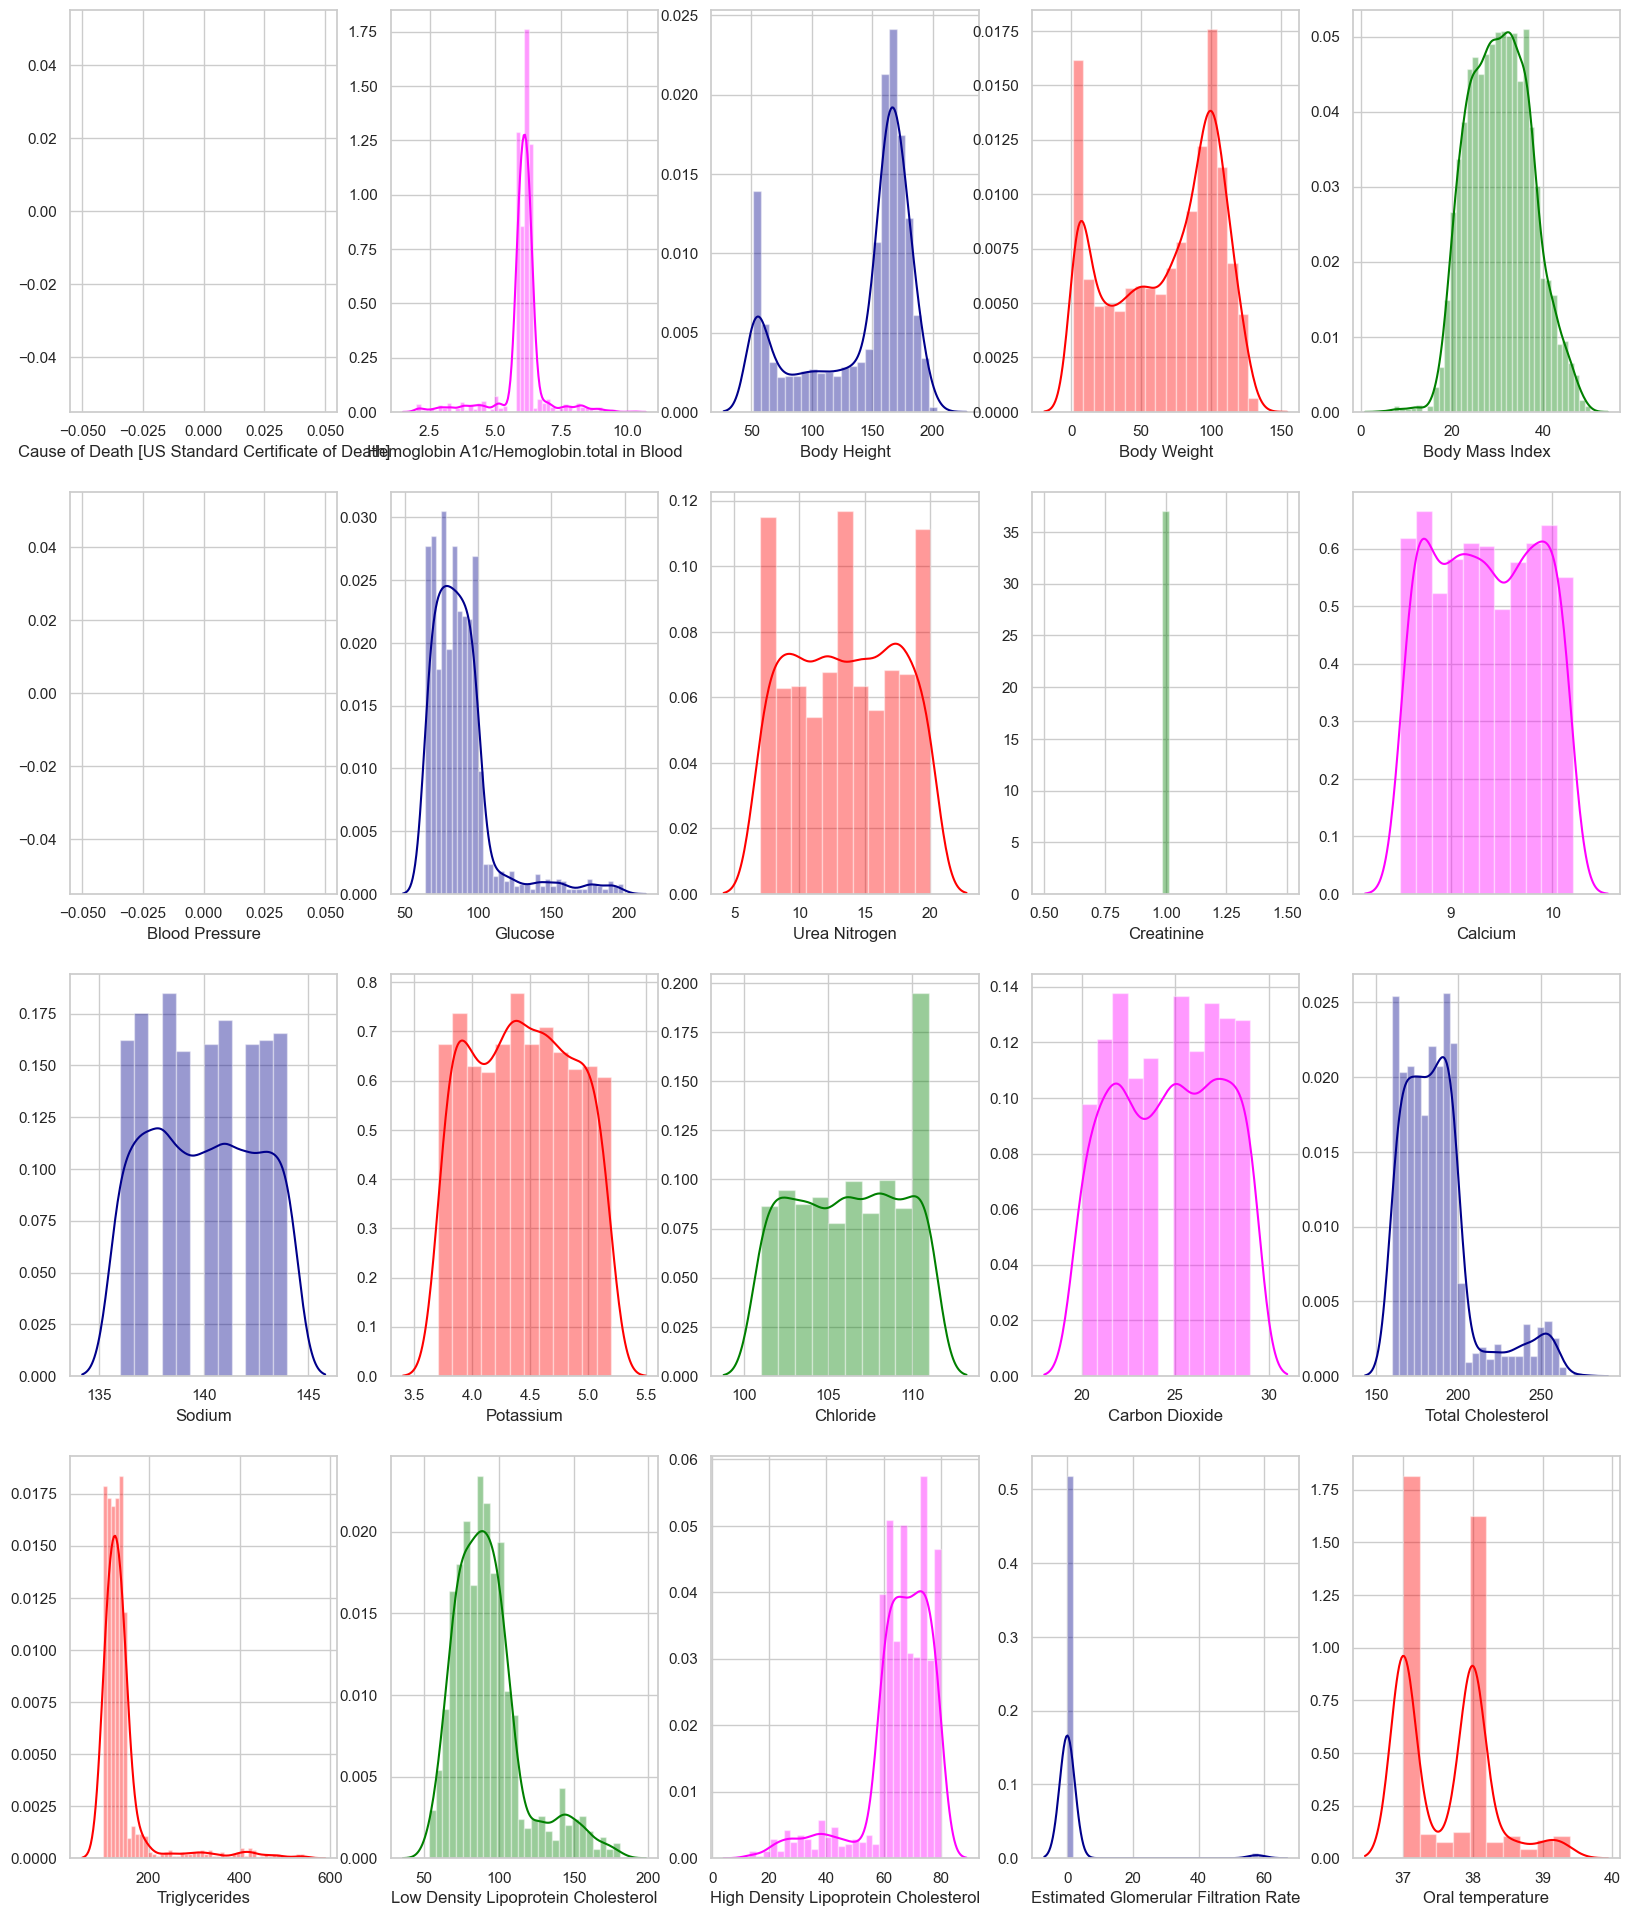

In [37]:
resource_code_display = observation_df["resource.code.display"].unique()
f, ax = plt.subplots(4, 5, figsize=(20, 24))
i = 0
colors = ["red", "green", "magenta", "darkblue"]
for display in resource_code_display[0:20]:
    i += 1
    plt.subplot(4, 5,i)
    sel_df = observation_df.loc[observation_df["resource.code.display"]==display]
    g = sb.distplot(sel_df["resource.valueQuantity.value"], color=colors[i%4])
    g.set(ylabel=None)
    g.set(xlabel=display)
plt.show()

urn:uuid:16f586c1-8124-4382-b36a-d99f8f0ee357


/var/folders/1w/l9hx8l952r57k_qmjhw7qc500000gn/T/ipykernel_81878/3523560566.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc=2, prop={'size': 3})


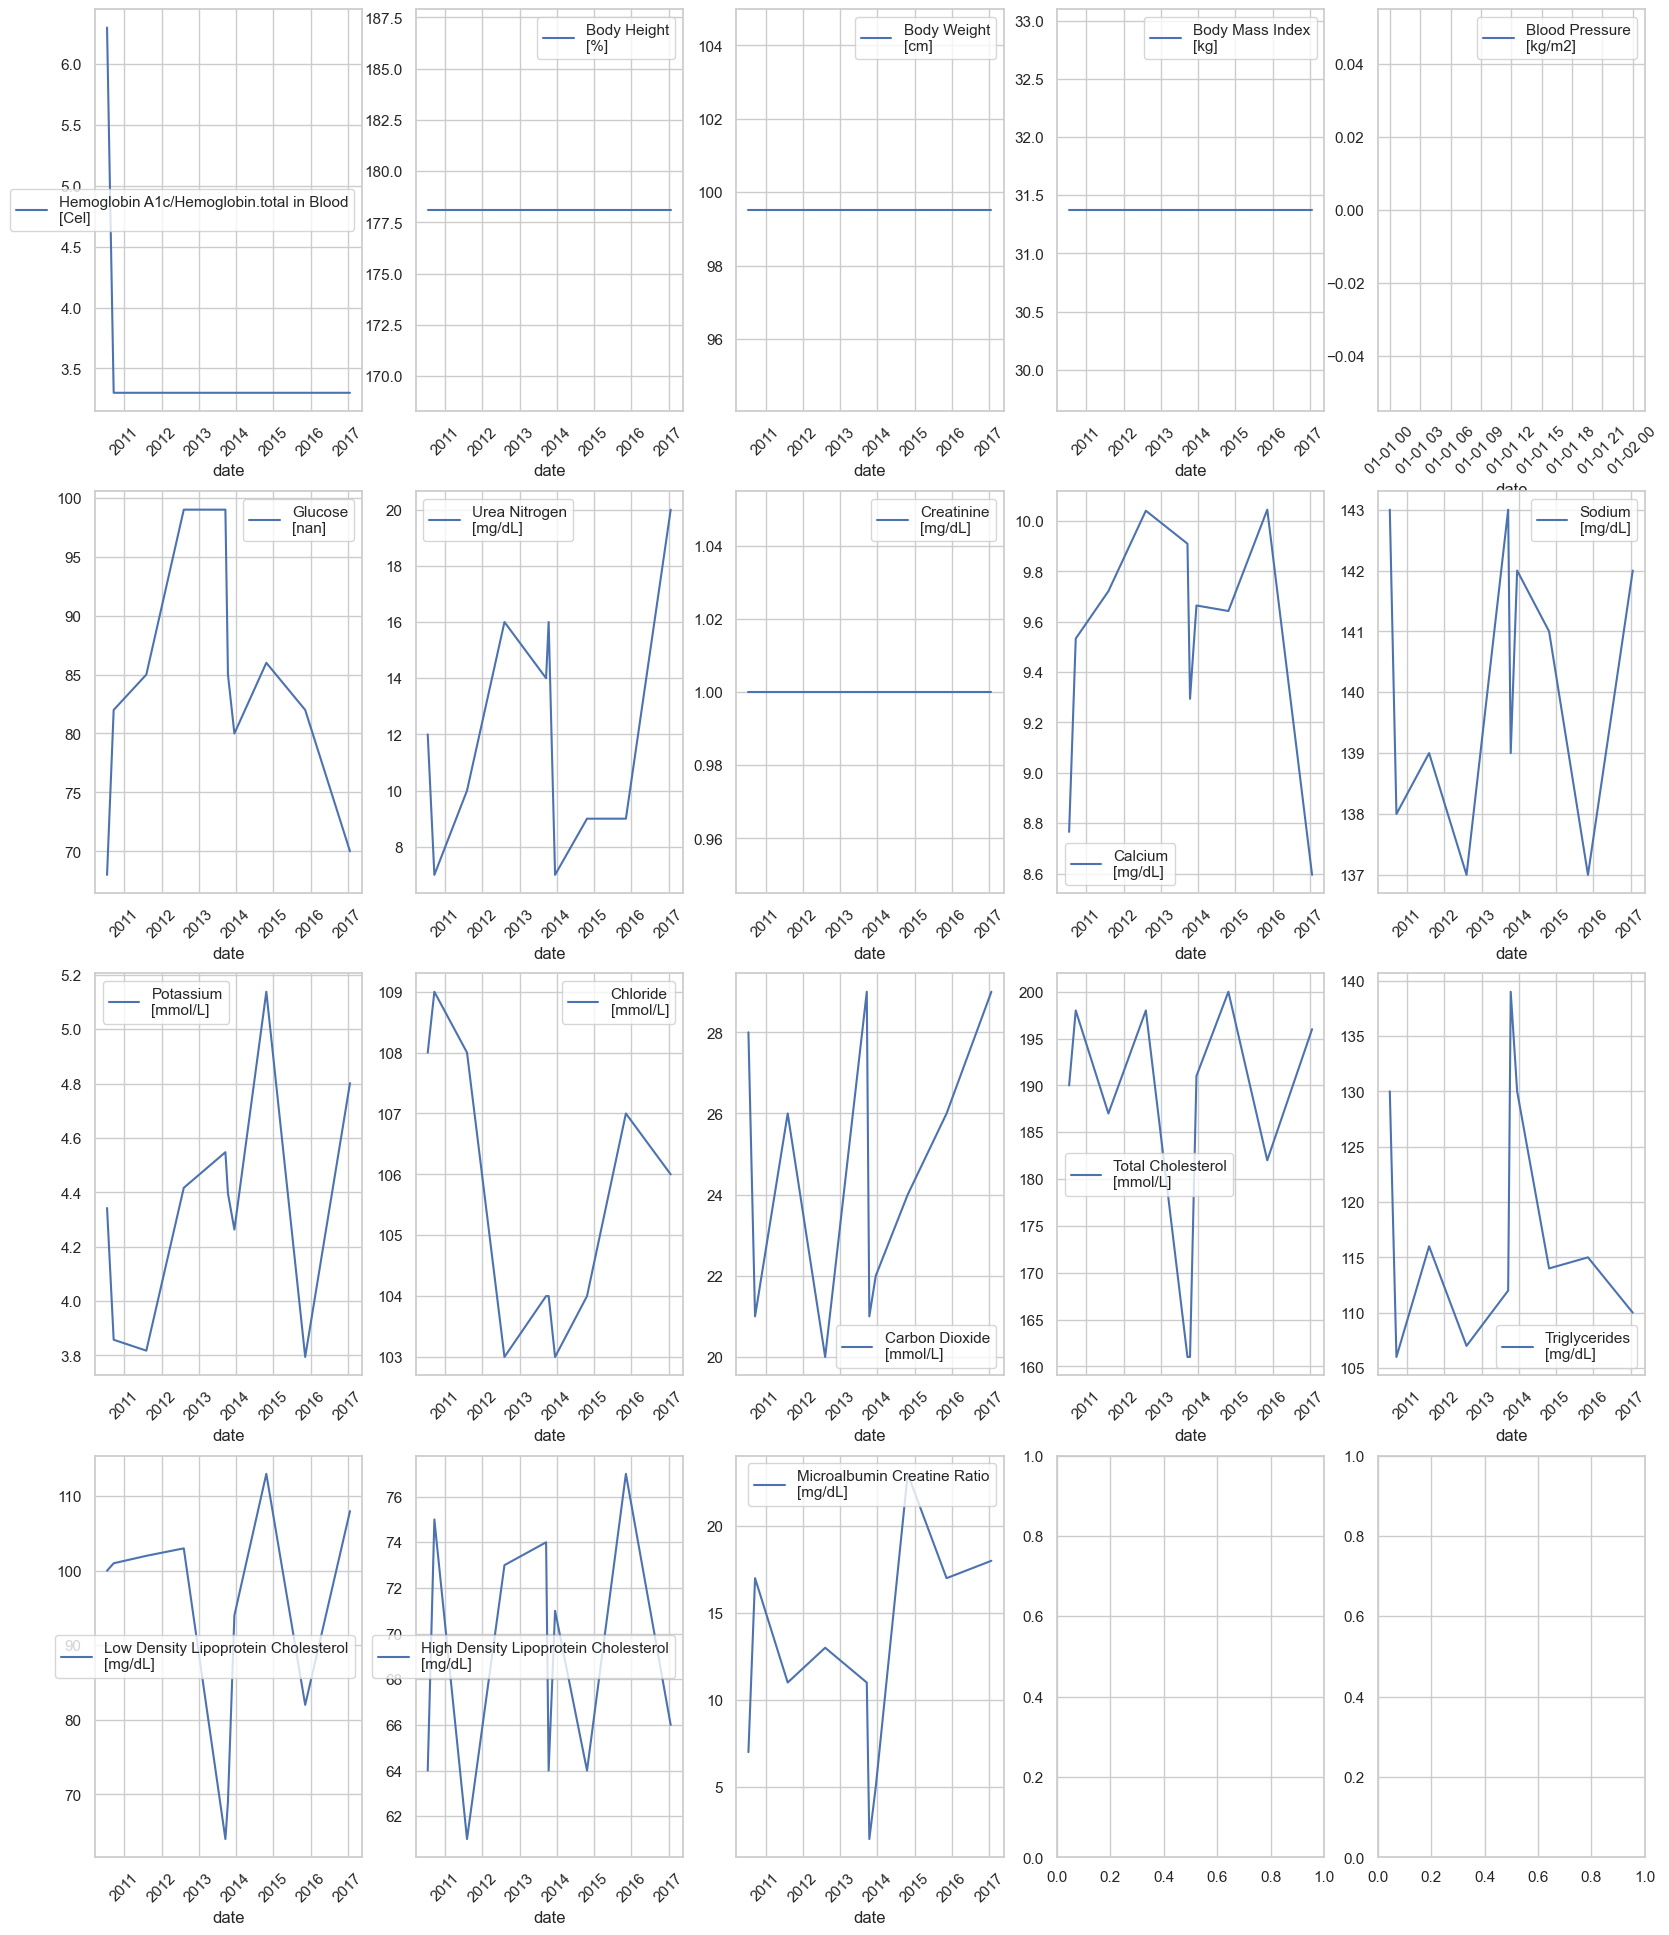

In [38]:
sel_patient = observation_df["resource.subject.reference"].value_counts().index[0]
print(sel_patient)
obs_subset_df = observation_df.loc[observation_df["resource.subject.reference"]==sel_patient]

sel_obs_columns = ["resource.code.display", "resource.effectiveDateTime", "resource.valueQuantity.value",
               "resource.valueQuantity.unit","resource.valueQuantity.system","resource.valueQuantity.code", "date"]


resource_code_display = obs_subset_df["resource.code.display"].unique()



f, ax = plt.subplots(4, 5, figsize=(20, 24))
i = 0
for display in resource_code_display[:-2]:
    i += 1
    plt.subplot(4, 5,i)
    plt.legend(loc=2, prop={'size': 3})
    label_text = f"{display}\n[{sel_df['resource.valueQuantity.code'].values[0]}]"
    sel_df = obs_subset_df.loc[obs_subset_df["resource.code.display"]==display]
    plt.plot(sel_df["date"], sel_df["resource.valueQuantity.value"], label=label_text)
    plt.tick_params(axis='x', rotation=45, size=6)
    plt.xlabel("date")
    plt.legend()
plt.show()
    

Selected patient: urn:uuid:8a7d1161-f041-4a5a-bb6b-103557f766d0


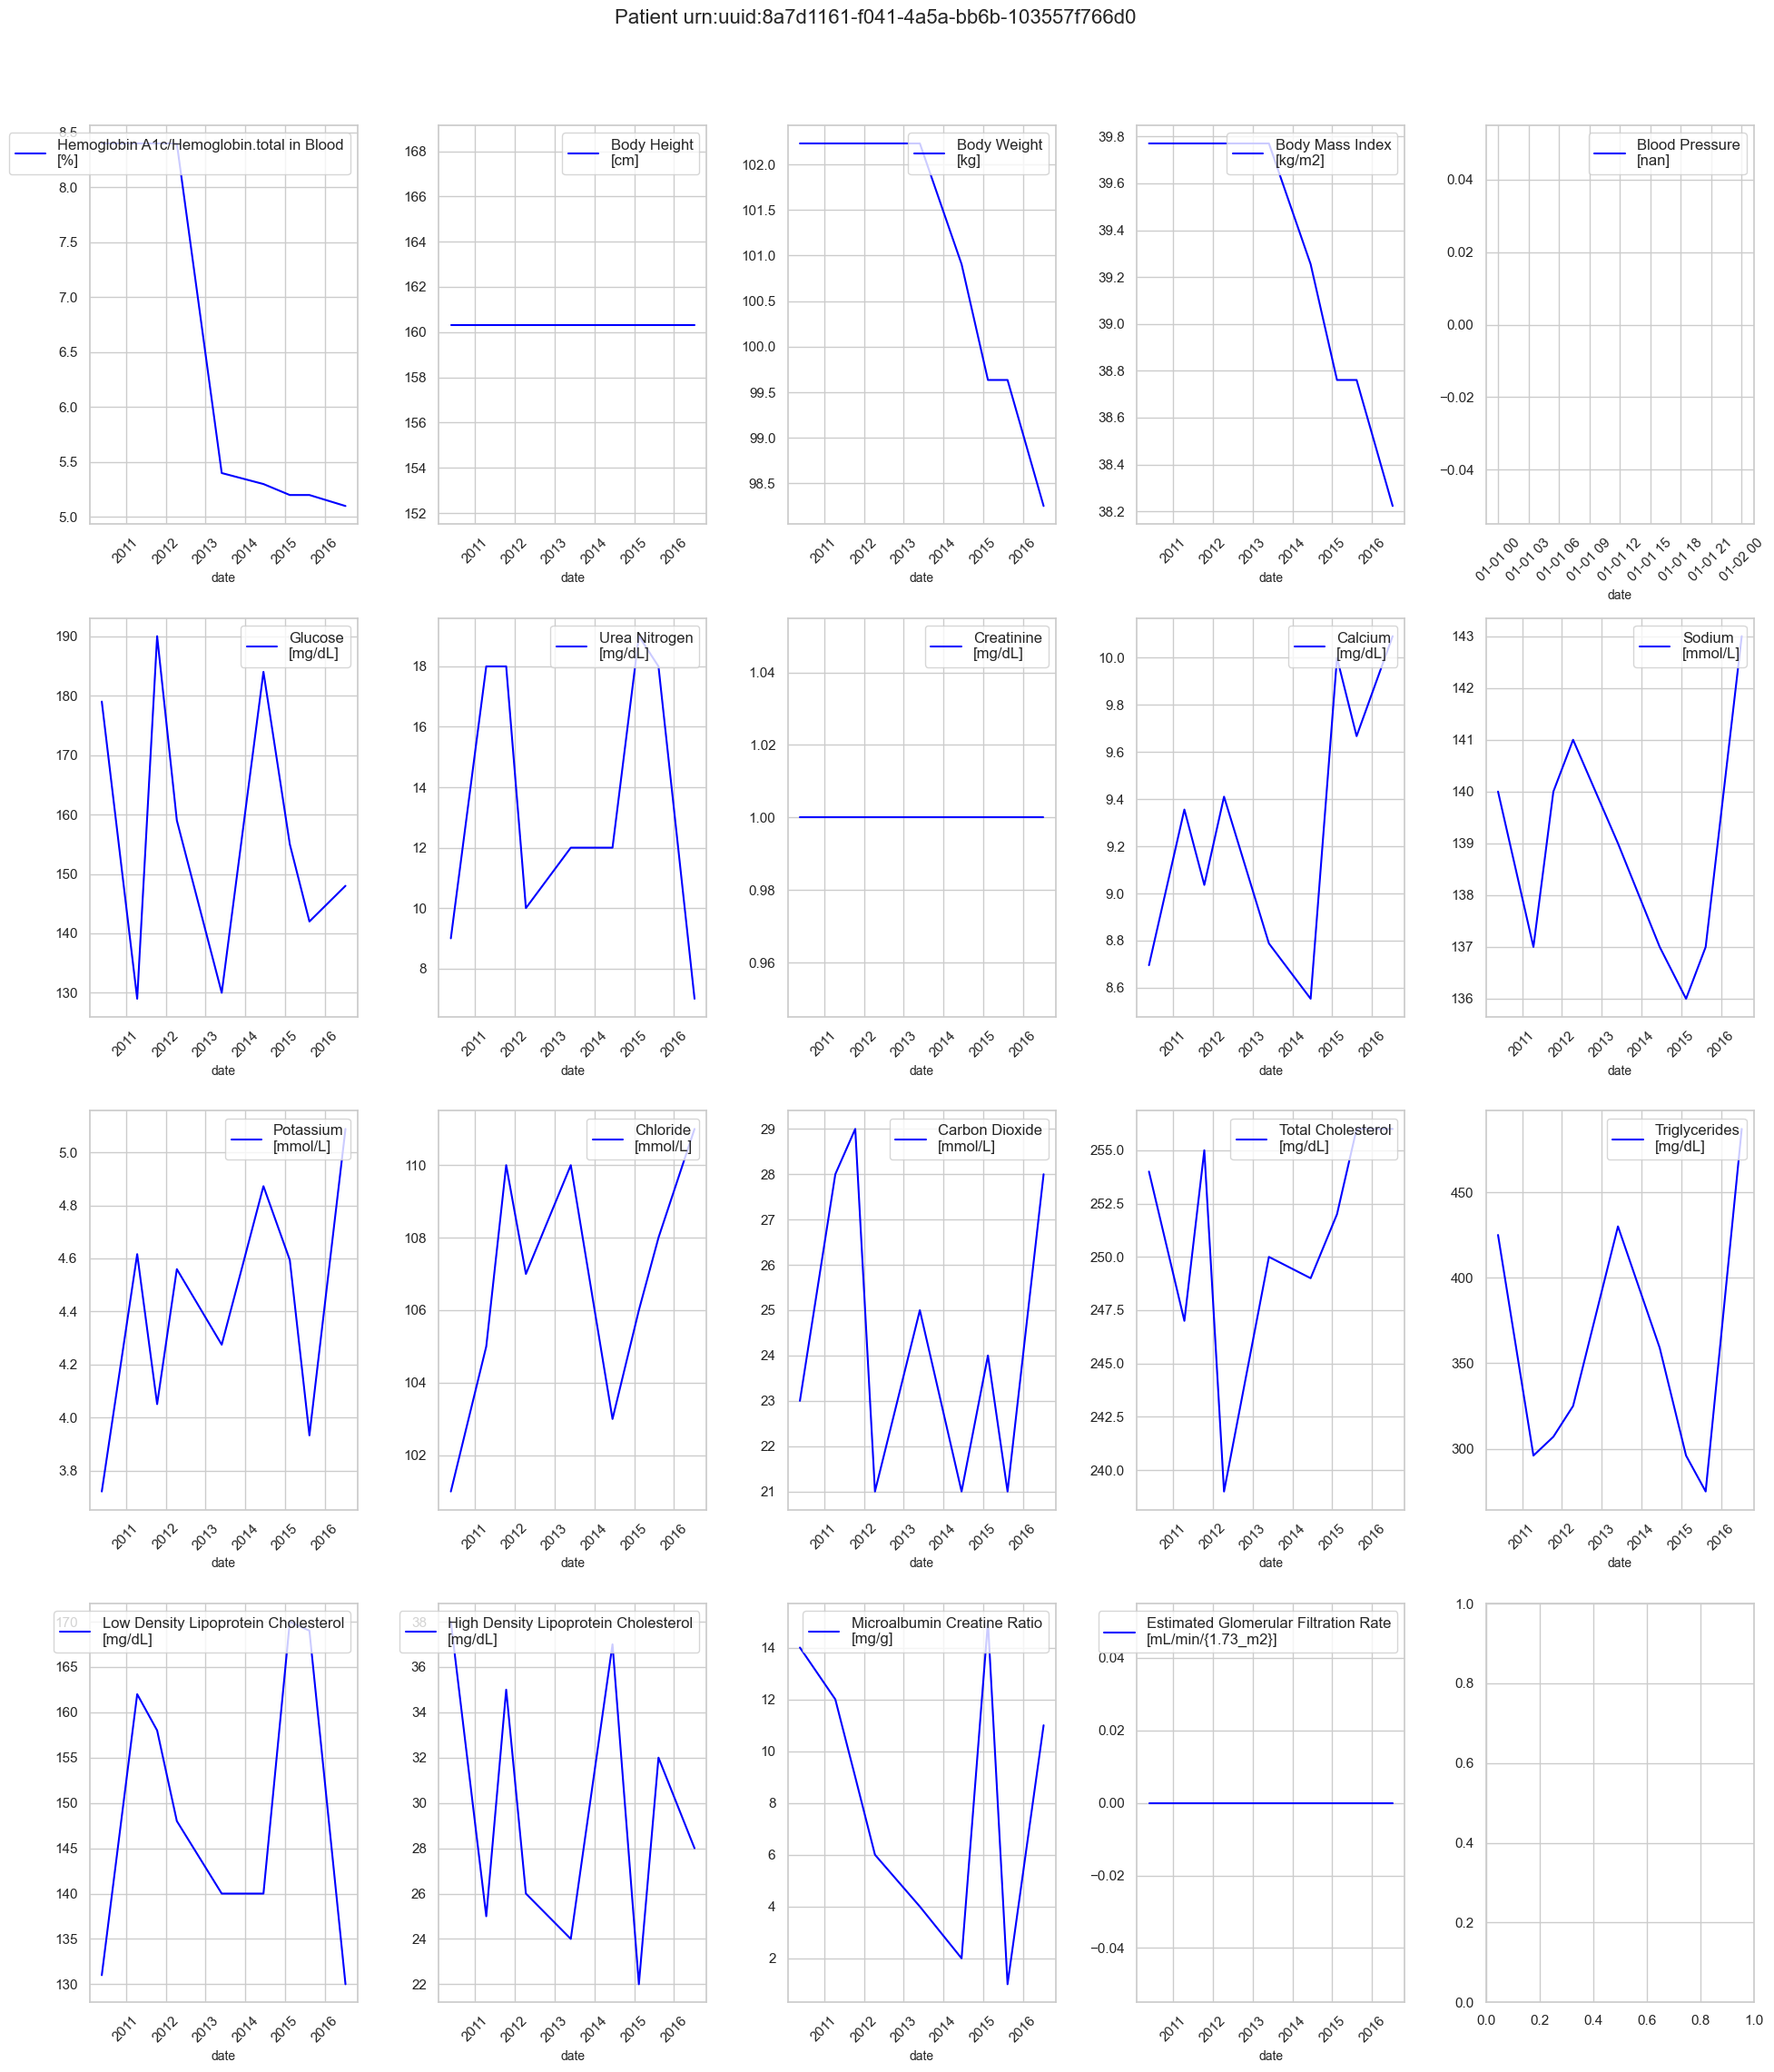

Selected patient: urn:uuid:6bda6597-e27a-4dbc-afa9-2e04cccb8bde


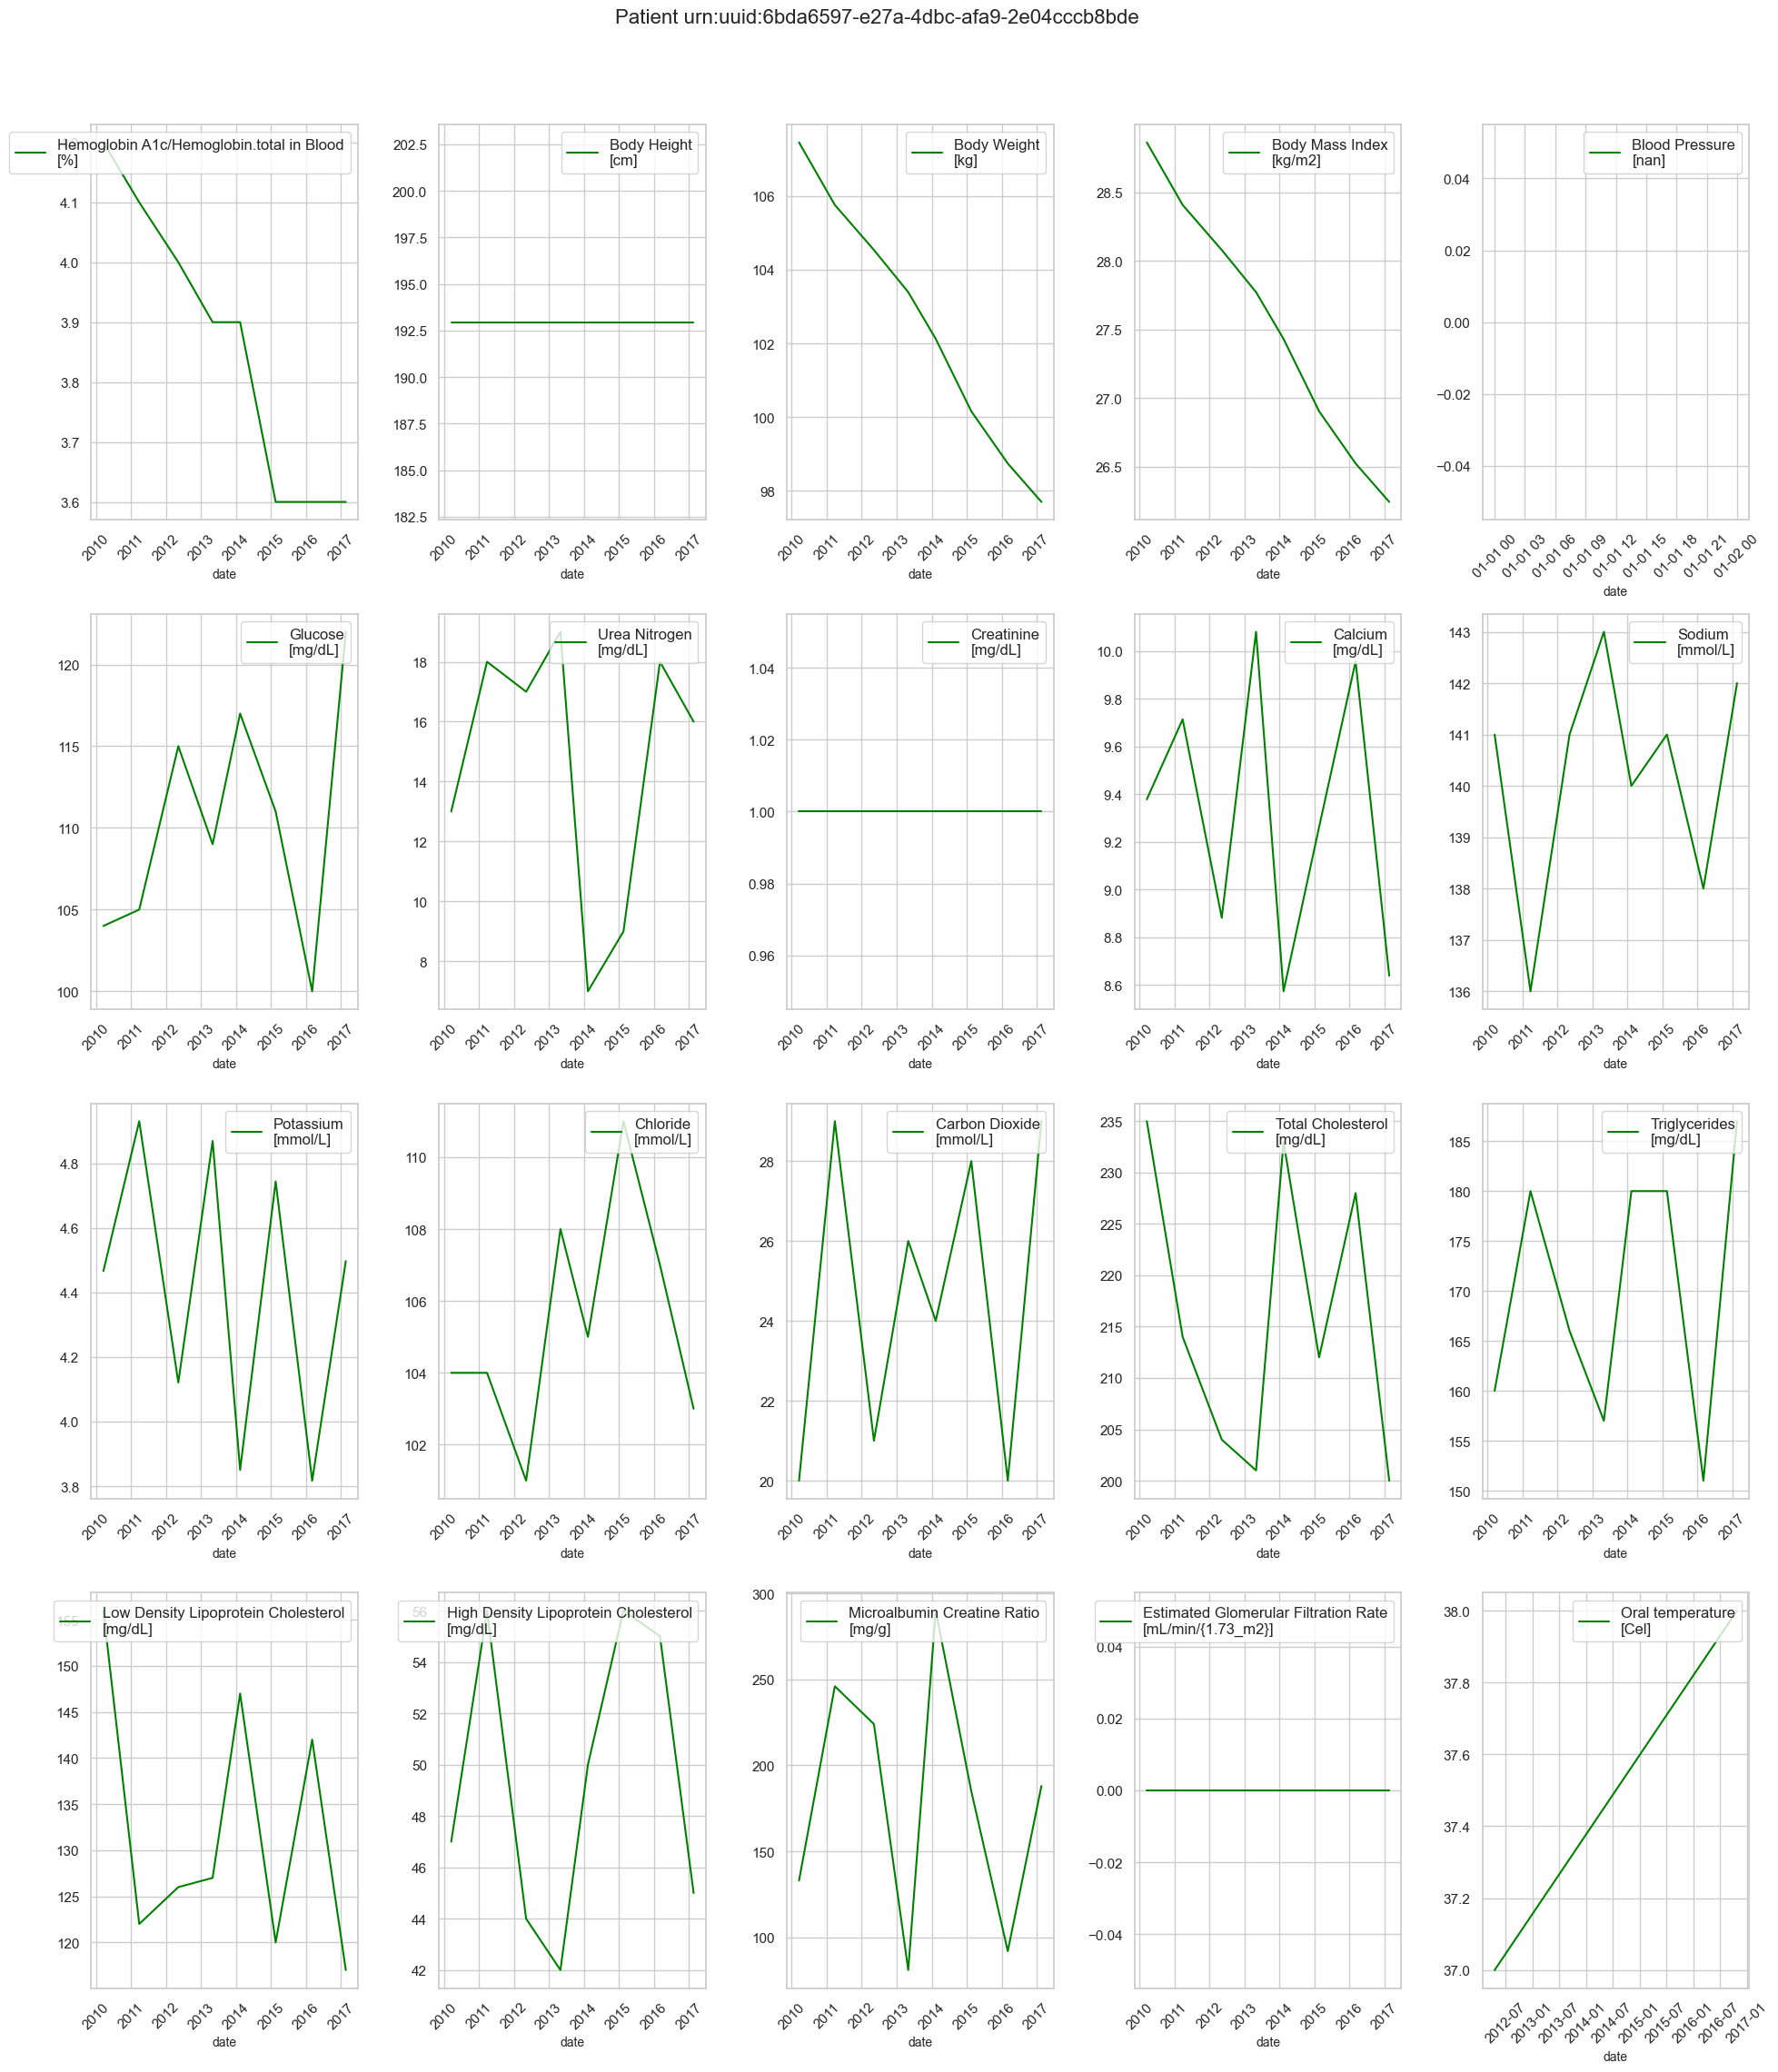

Selected patient: urn:uuid:f18d842b-f133-48b5-89c7-dcfd33333342


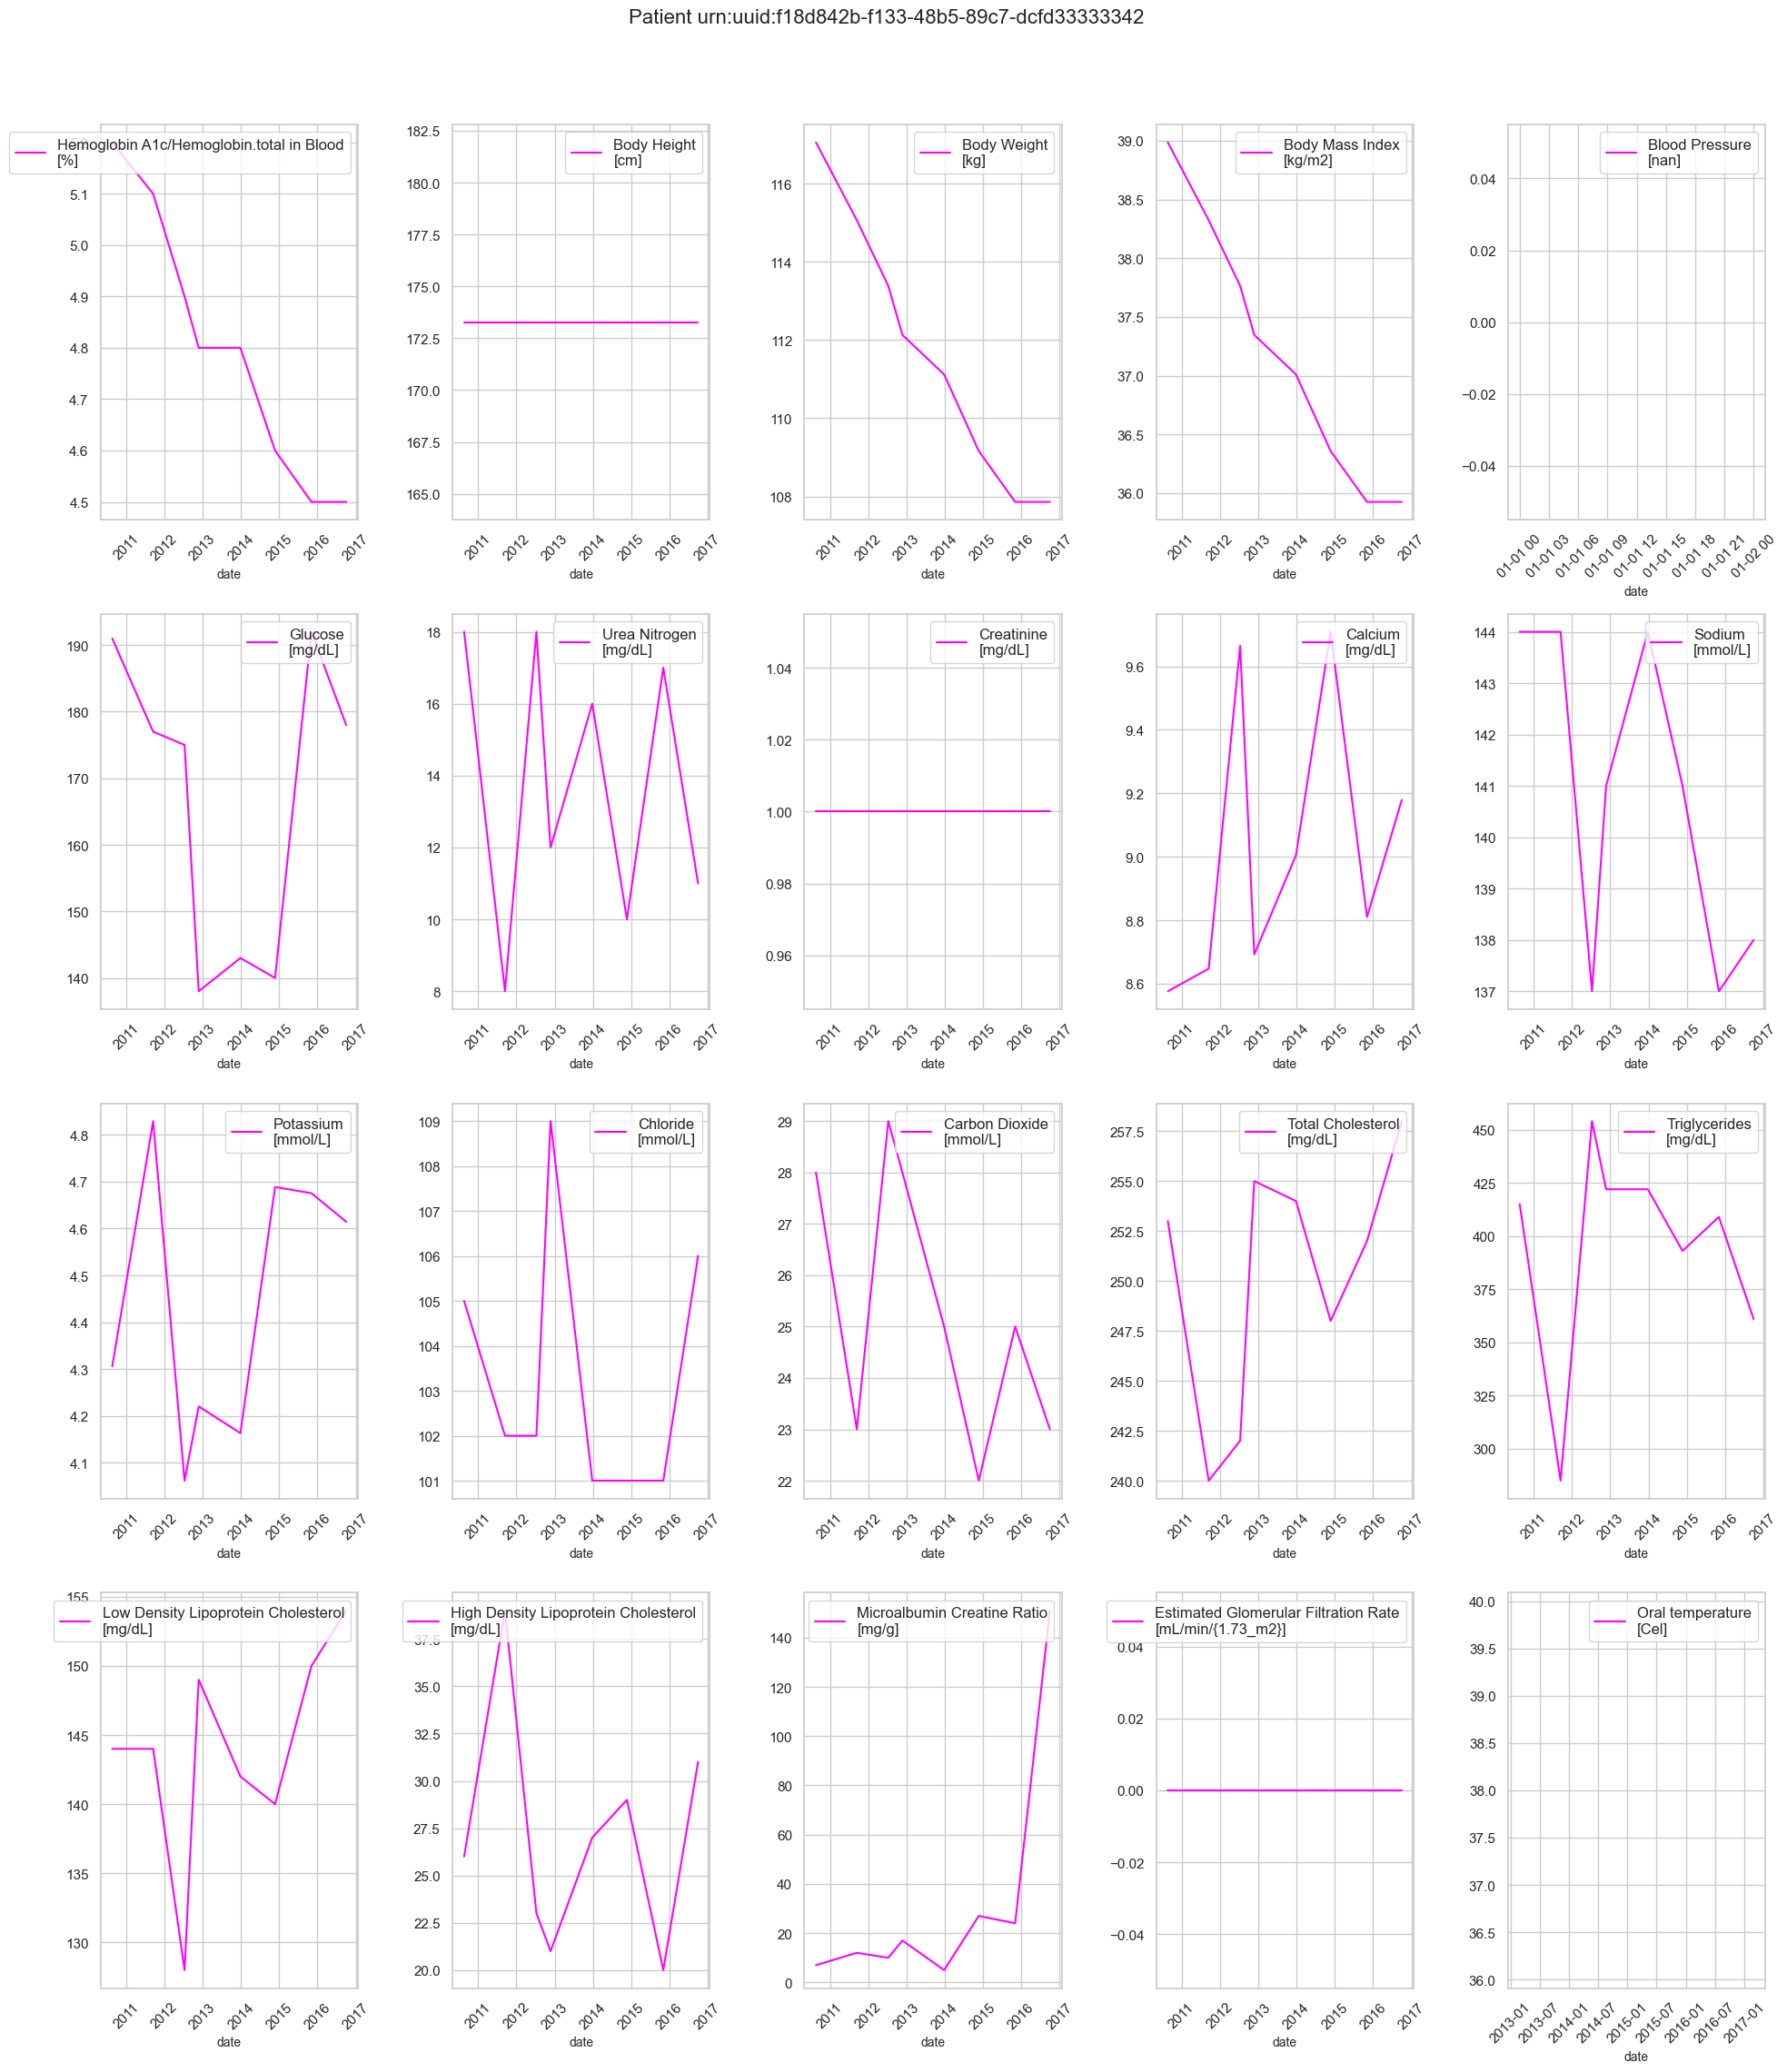

Selected patient: urn:uuid:87c5ab0b-e4a7-424b-8101-80150d30a4fe


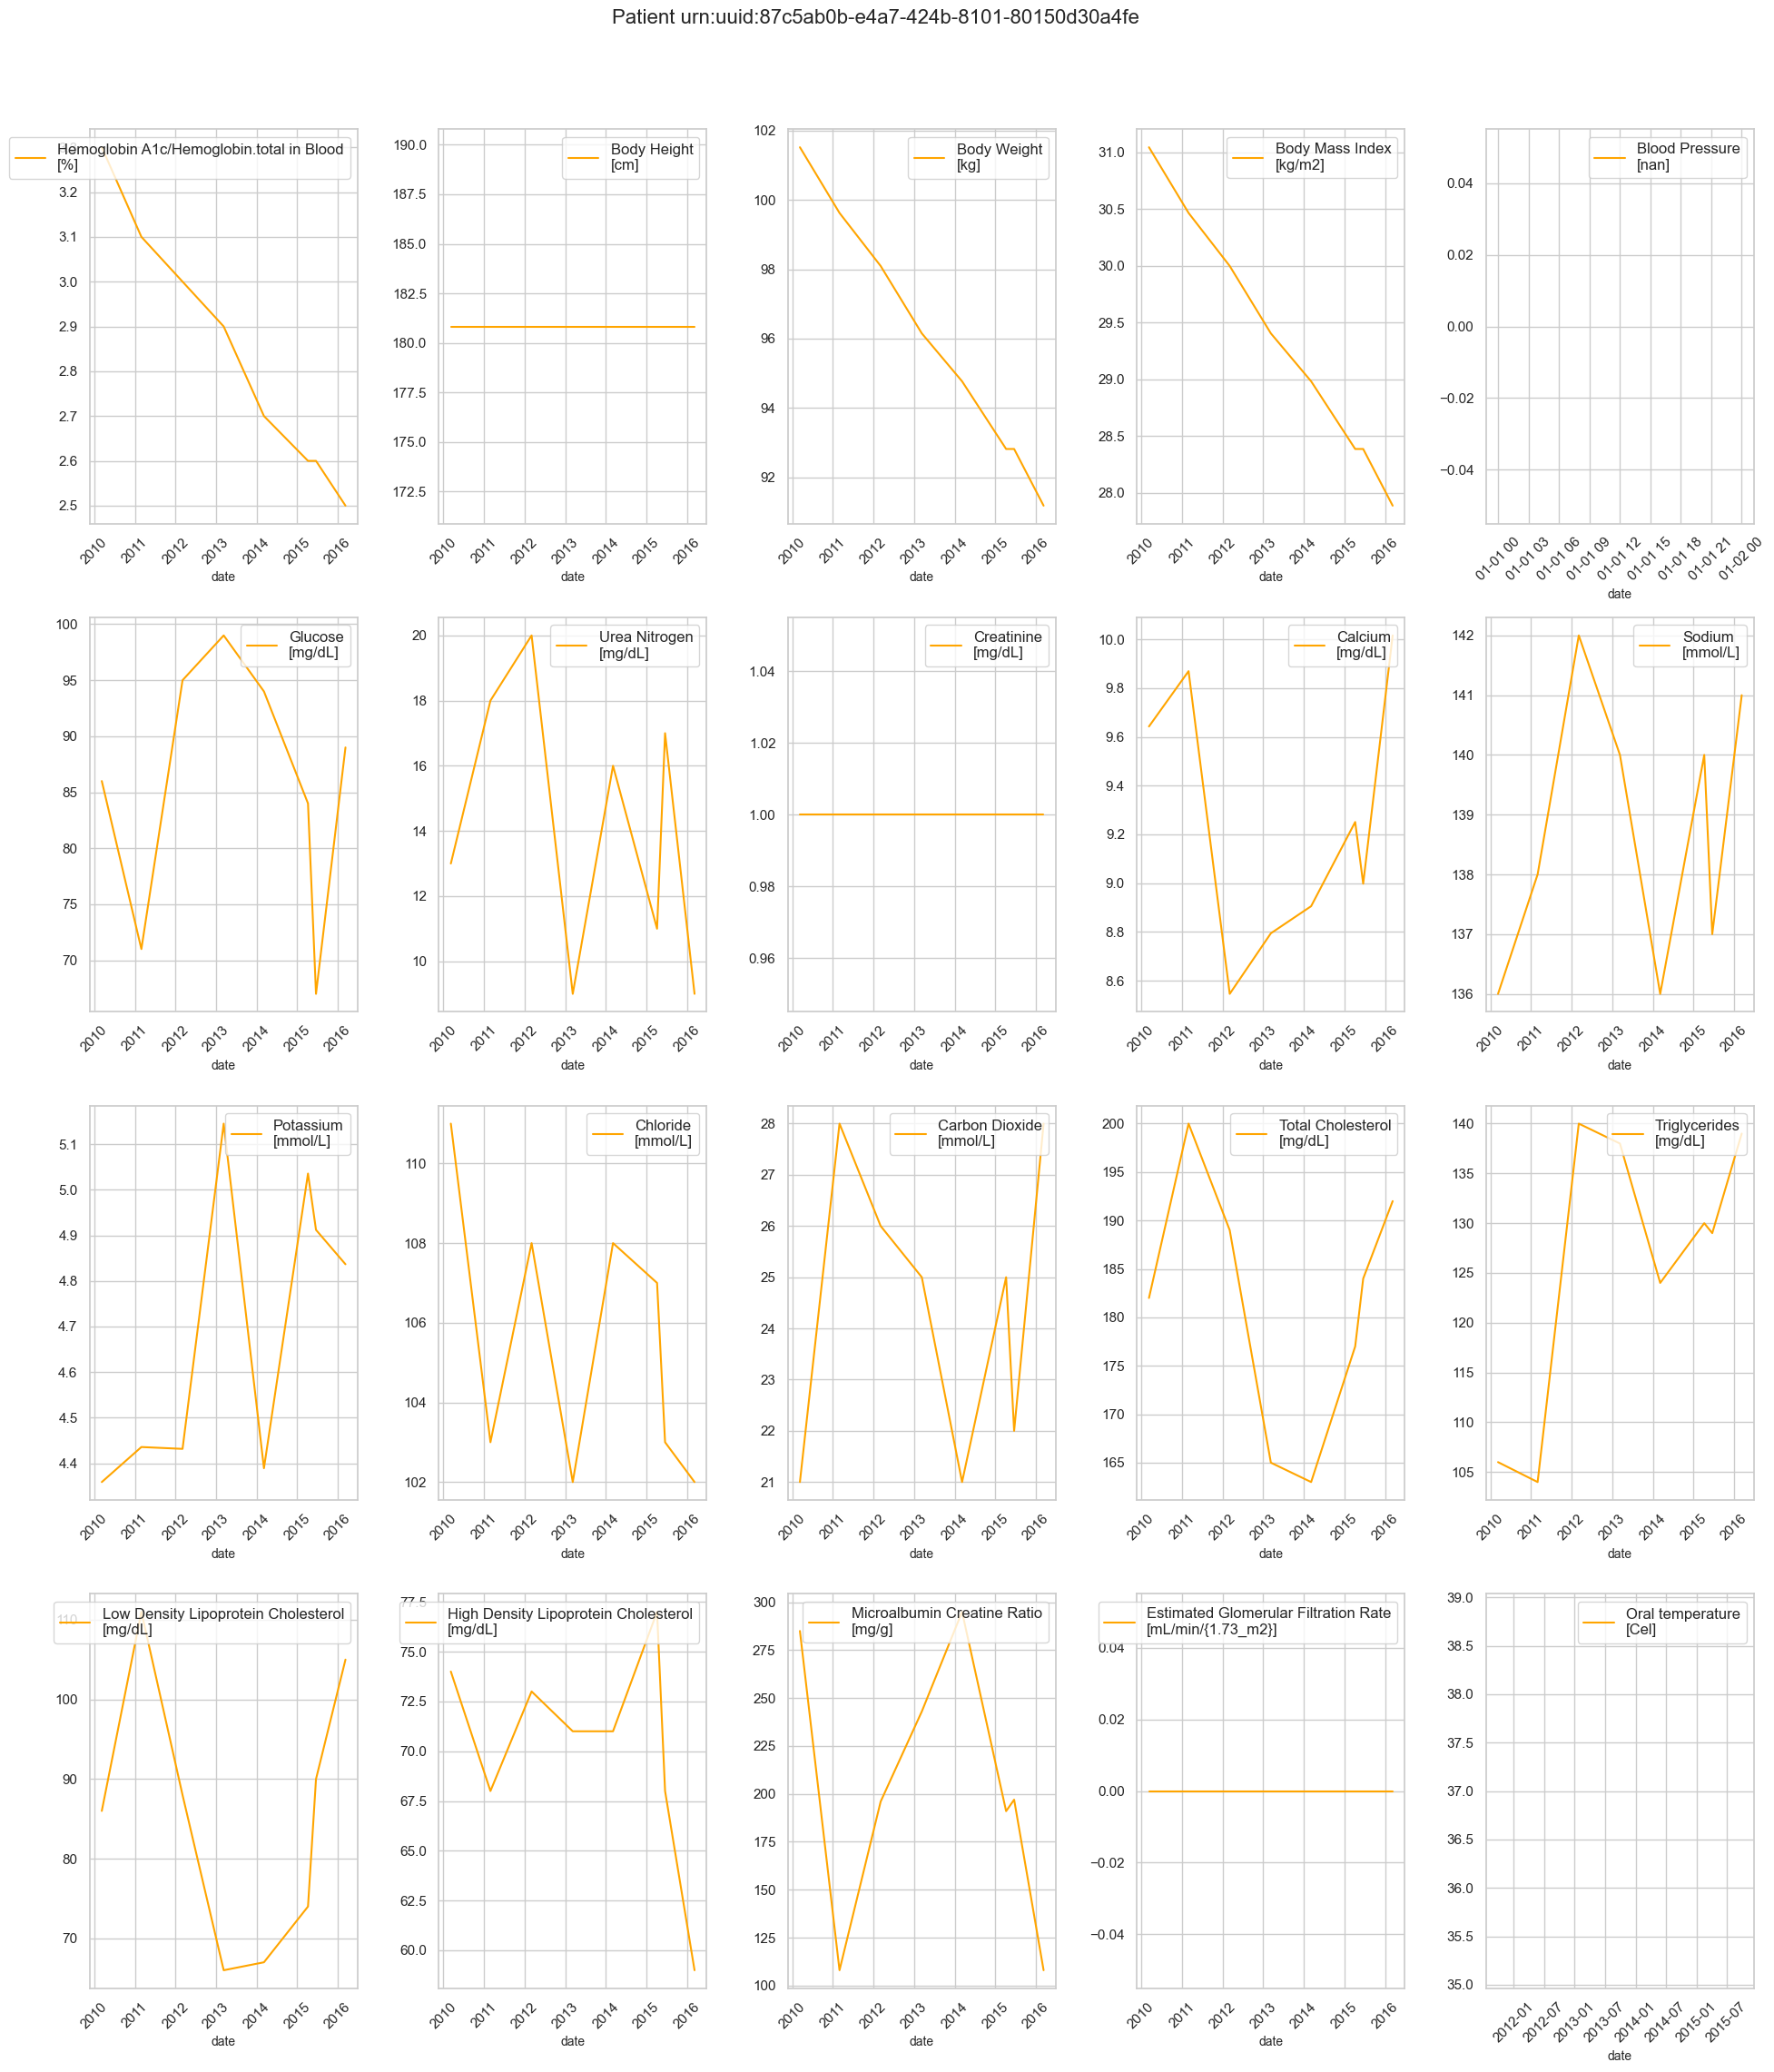

In [41]:


# Loop through patients
for idx in range(1, 5):
    sel_patient = observation_df["resource.subject.reference"].value_counts().index[idx]
    print(f"Selected patient: {sel_patient}")
    obs_subset_df = observation_df.loc[observation_df["resource.subject.reference"] == sel_patient]
    resource_code_display = obs_subset_df["resource.code.display"].unique()
    colors = ["red", "blue", "green", "magenta", "orange"]
    
    # Create the figure and axes grid
    f, ax = plt.subplots(4, 5, figsize=(20, 24))
    f.suptitle(f"Patient {sel_patient}", fontsize=16)
    
    for i, display in enumerate(resource_code_display[0:20]):
        row = i // 5
        col = i % 5
        
        # Select data for the current display
        sel_df = obs_subset_df.loc[obs_subset_df["resource.code.display"] == display]
        
        # Prepare label and color
        label_text = f"{display}\n[{sel_df['resource.valueQuantity.code'].values[0]}]"
        color = colors[idx % len(colors)]
        
        # Plot on the correct subplot
        ax[row, col].plot(sel_df["date"], sel_df["resource.valueQuantity.value"], label=label_text, color=color)
        ax[row, col].tick_params(axis='x', rotation=45, size=6)
        ax[row, col].set_xlabel("date", fontsize=10)
        ax[row, col].legend(loc='upper right', prop={'size': 12})  # Increase legend font size to 8
    
    # Show the full figure with all subplots after the inner loop completes
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

In [30]:
'''     patient_df,\
    careplan_df,\
    condition_df,\
    diagnostic_report_df,\
    encounter_df,\
    immunization_df,\
    observation_df,\
    procedure_df = \
    process_one_file(sample_df,patient_df,
    careplan_df,
    condition_df,
    diagnostic_report_df,
    encounter_df,
    immunization_df,
    observation_df,
    procedure_df'''

obs_subset_df = observation_df.loc[observation_df["resource.subject.reference"]==sel_patient]
resource_code_display = obs_subset_df["resource.code.display"].unique()

def extract_one_patient(df, patient):
    #if the df causes an error, print the df
    try:
        sel_df = df.loc[df["resource.subject.reference"]==patient]
    except:
        print(df)
        return None
    return sel_df
    
patient_history = pd.DataFrame()
for df in [patient_df, careplan_df, condition_df, diagnostic_report_df, encounter_df, immunization_df, observation_df, procedure_df]:
    #add the df to the patient history
    patient_history = pd.concat([patient_history, extract_one_patient(df, sel_patient)])



                                          fullUrl  \
0   urn:uuid:79768ddb-fa8a-4ce8-b9dd-139d10a3b9a1   
0   urn:uuid:1117ae06-e920-4768-a351-f0db77a1edaa   
0   urn:uuid:88c50d56-619e-42b5-a7ba-4c864c2f4f5f   
0   urn:uuid:a3f267fd-dd43-42da-877a-9d04d6a9bb79   
0   urn:uuid:aeb820cc-8a4d-4e4c-89b2-bdd1d7a40e98   
..                                            ...   
0   urn:uuid:f1cb684d-4fc8-4856-8e79-d4a0e9d291b7   
0   urn:uuid:0b1c4d02-936c-4c6a-82de-c28eb85fdc0c   
0   urn:uuid:63e3efe5-b6fe-4afb-aeb2-48694813758d   
0   urn:uuid:ae0c691c-2322-4a21-828c-97d8fc24e740   
0   urn:uuid:9da9a10b-3051-4921-ae71-e526a7ef0c35   

                             resource.id resource.text.status  \
0   79768ddb-fa8a-4ce8-b9dd-139d10a3b9a1            generated   
0   1117ae06-e920-4768-a351-f0db77a1edaa            generated   
0   88c50d56-619e-42b5-a7ba-4c864c2f4f5f            generated   
0   a3f267fd-dd43-42da-877a-9d04d6a9bb79            generated   
0   aeb820cc-8a4d-4e4c-89b2-bdd1d7a40e

In [31]:
for index, row in patient_history.iterrows():
    if row["resource.resourceType"]=="Observation":
        row['fullDate'] = row['date']
    if row["resource.resourceType"]=="Procedure":
        row['fullDate'] = row['resource.performedPeriod.start']
    if row["resource.resourceType"]=="DiagnosticReport":
        row['fullDate'] = row['resource.issued']
    if row["resource.resourceType"]=="Condition":
        row['fullDate'] = row['resource.onsetDateTime']
    if row["resource.resourceType"]=="CarePlan":
        row['fullDate'] = row['resource.period.start']

patient_history['fullDate']
    
    


KeyError: 'fullDate'